In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score


In [ ]:
data = pd.read_csv("/content/phishing_5_percent.csv")

# Voir les 5 premières lignes

print(data['label'].value_counts())
data.head()

label
0    15770
1      830
Name: count, dtype: int64


,subject,body,label
0,fw : proposed 2002 canada service agreeemnt,"hi louise ,\r\ni am hearing that you and rob d...",0
1,latest enron business issue up,? dealbench and the art of the paperless deal ...,0
2,urgent,the associate and analyst recruiting departmen...,0
3,2001 vacation,i am planning to take a three week vacation in...,0
4,re : helsinki report,"fernley ,\r\ngenerally , this seems to be fine...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16600 entries, 0 to 16599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  16590 non-null  object
 1   body     16600 non-null  object
 2   label    16600 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 389.2+ KB


In [ ]:
#RÉPARER LE TEXTE
texts = data['body'].astype(str).values
labels = data['label'].values

In [ ]:
#TOKENISATION
MAX_WORDS = 10000     # vocabulaire
MAX_LEN = 200         # longueur max d’un email

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


In [ ]:
len(tokenizer.word_index)


87361

In [ ]:
list(tokenizer.word_index.items())[:10]


[('<OOV>', 1),
 ('the', 2),
 ('\r', 3),
 ('to', 4),
 ('and', 5),
 ('of', 6),
 ('a', 7),
 ('in', 8),
 ("'", 9),
 ('enron', 10)]

In [ ]:
print(texts[0])
print(sequences[0])


hi louise ,
i am hearing that you and rob discussed the canada svc agreement and settled on a number in the ballpark of $ 7 m , which is comparable to last year . there is one change from last year that we may want to consider - the treatment of the regulatory affairs activity charged from corporate . last year rob was not burdened with this cost . this year we discussed pushing these costs to the appropriate commercial teams . please review the two attachments below and advise . currently our proposed service agreement amount totals $ 10 m .
- - - - - original message - - - - -
from : leschber , edie
sent : wednesday , october 31 , 2001 12 : 48 pm
to : killen , faith
subject : re : proposed 2002 canada service agreeemnt
the public affairs amount included in the agreement currently is $ 2 , 156 , 000 . see attached schedule for calculation . in the prior year , we did not include an amount for public affairs in the agreement .
[ killen , faith ]
- - - - - original message - - - - -
fro

In [ ]:
print(len(sequences[0]))
print(len(padded_sequences[0]))


377
200


In [ ]:
padded_sequences.shape

(16600, 200)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=MAX_WORDS, output_dim=128))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9319 - auc: 0.7466 - loss: 0.2125 - precision: 0.2490 - recall: 0.0863 - val_accuracy: 0.9759 - val_auc: 0.9747 - val_loss: 0.0648 - val_precision: 0.8600 - val_recall: 0.6324
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9842 - auc: 0.9897 - loss: 0.0433 - precision: 0.8690 - recall: 0.8182 - val_accuracy: 0.9782 - val_auc: 0.9807 - val_loss: 0.0594 - val_precision: 0.9333 - val_recall: 0.6176
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9941 - auc: 0.9993 - loss: 0.0156 - precision: 0.9569 - recall: 0.9221 - val_accuracy: 0.9827 - val_auc: 0.9583 - val_loss: 0.0705 - val_precision: 0.9091 - val_recall: 0.7353
Epoch 4/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9983 - auc: 0.9945 - loss: 0.0066 - precision: 0.9856 - recall: 0.9721 - val_accuracy: 0.9812 - val_auc: 0.8946 - val_loss: 0.1233 - val_precision: 1.0000 - val_recall: 0.6324
Epoch 5/5
374/374 ━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Prédictions (IMPORTANT)
y_pred_prob = model.predict(X_test).ravel()

# Courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_pred_prob
)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Meilleur seuil
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print("Meilleur seuil :", best_threshold)
print("Precision :", precision[best_index])
print("Recall :", recall[best_index])
print("F1-score :", f1_scores[best_index])

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Meilleur seuil : 0.5597787
Precision : 0.9066666666666666
Recall : 0.8192771084337349
F1-score : 0.8607594886837044


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= best_threshold).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[3140   14]
 [  30  136]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3154
           1       0.91      0.82      0.86       166

    accuracy                           0.99      3320
   macro avg       0.95      0.91      0.93      3320
weighted avg       0.99      0.99      0.99      3320



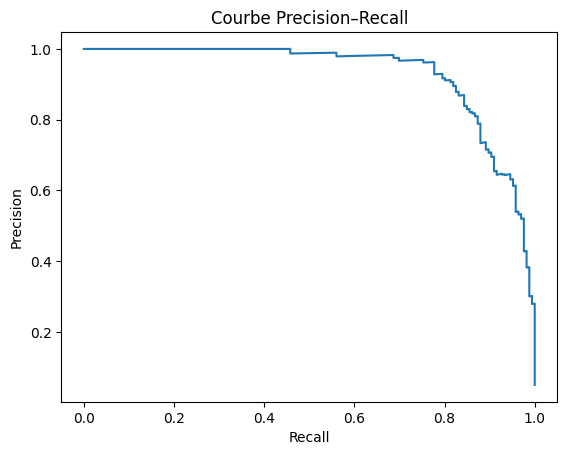

In [ ]:

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision–Recall")
plt.show()

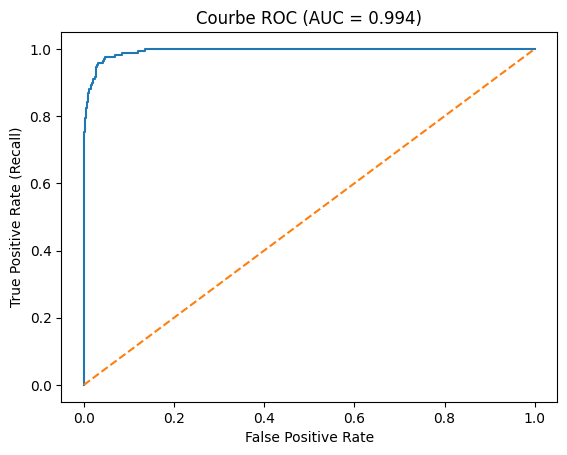

In [ ]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"Courbe ROC (AUC = {auc_score:.3f})")
plt.show()